In [37]:
import warnings; warnings.simplefilter('ignore')

In [47]:
import os
import numpy as np
import sys
caffe_root = '/home/stephanos/Development/caffe-master/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import pickle
import caffe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the R-CNN model from disk...

caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

rcnn_model_def = caffe_root + "models/bvlc_reference_rcnn_ilsvrc13/deploy.prototxt"
rcnn_model_weights = caffe_root + 'models/bvlc_reference_rcnn_ilsvrc13/bvlc_reference_rcnn_ilsvrc13.caffemodel'

rcnn_net = caffe.Net(rcnn_model_def, rcnn_model_weights, caffe.TEST)


# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': rcnn_net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
rcnn_net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

# load ML models
gb = pickle.load(open('gbFinal','rb'))
countvect = pickle.load(open('countvect','rb'))


def getPrice(imagePath, title):    

    #show the image
    img = mpimg.imread('your_image.png')
    imgplot = plt.imshow(img)
    plt.show()
    
    # transform the image and copy it into the net
    image = caffe.io.load_image(imagePath)
    
    height = np.size(image, 0)
    width = np.size(image, 1)
    ratio = height / width
    
    if height >= width:
        height = 227
        width = height / ratio
    else:
        width = 227
        height = width * ratio
    
    image = caffe.io.resize_image( image, (int(height),int(width)), interp_order=3 )
    
    rcnn_net.blobs['data'].data[...] = transformer.preprocess('data', image)

    # perform classification
    output = rcnn_net.forward()
    
    # Get the features:
    features = rcnn_net.blobs.get('fc7').data[0].tolist()
        
    # Combine image features and title features:
    #allfeatures = hstack(features.values, countvect.fit_transform(['title'])).toarray()
    
    #print(type(features))
    #print(type(countvect.transform([title]).toarray()[0]))
    allfeatures = features + countvect.transform([title]).toarray()[0].tolist()
    #print(len(allfeatures))
    
    #get the price
    return gb.predict(features + countvect.transform([title]).toarray()[0].tolist())[0]
    #return gb.predict(allfeatures)[0]

mean-subtracted values: <zip object at 0x7f43db335188>


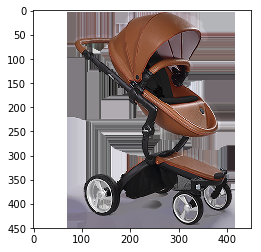

142.847636873


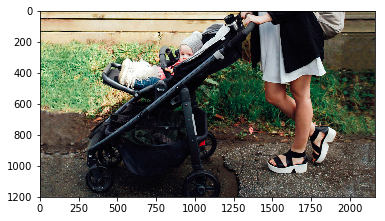

48.8540609585


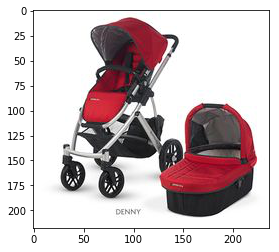

227.03586958


In [48]:
test1 = 'stroller_brown.png'
test2 = 'stroller_unclear.jpg'
test3 = 'stroller_carryon.jpg'

print(getPrice(test1, "Brown stroller"))
print(getPrice(test2, "Black Stroller"))
print(getPrice(test3, "Stroller with car seat"))
